In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
# Any results you write to the current directory are saved as output.

# Loading and Preparing Dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class MNIST_Dataset(Dataset):
    
    def __init__(self, X, y, transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))])):
            
        self.transform = transform
        self.X = X.reshape((-1,56,56)).astype(np.uint8)[:,:,:,None]
        self.y = y
        
    @classmethod
    def from_train(cls, file_path_images, file_path_labels):
        train_images = pd.read_pickle(file_path_images)
        train_labels = pd.read_csv(file_path_labels)
        
        return cls(X=train_images, y=torch.from_numpy(train_labels['Category'].values))
        
    @classmethod
    def from_test(cls, file_path_images):
        test_images = pd.read_pickle(file_path_images)
        
        return cls(X=test_images, y=None)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.transform(self.X[idx])
        # X = X.to(device)
        if self.y is not None:
            return X, self.y[idx]   #.to(device)
        else:
            return X

In [3]:
train_data = pd.read_pickle('images_l.pkl')
train_labels = pd.read_pickle('labels_l.pkl')
test_data = pd.read_pickle('images_test.pkl')

number_train_images = int(train_data.shape[0] * 0.9)

X_train = train_data[:number_train_images]
y_train = train_labels[:number_train_images]
print(X_train.shape)
print(y_train.shape)

X_validation = train_data[number_train_images:]
y_validation = train_labels[number_train_images:]

print(X_validation.shape)
print(y_validation.shape)
print(test_data.shape)

(27000, 56, 56)
(27000, 36)
(3000, 56, 56)
(3000, 36)
(15000, 56, 56)


In [4]:
batch_size = 32

train_dataset = MNIST_Dataset(X_train, y_train)
validation_dataset = MNIST_Dataset(X_validation, None)
test_dataset = MNIST_Dataset.from_test('images_test.pkl')
    
# Loading
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

# Neural Network Architecture, and Optimizer, and Loss Functions

In [3]:
class ConvNet_3Layers(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.5):
        super(ConvNet_3Layers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=28, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(28, 28, 2),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(28, 56, 2),
            nn.ReLU(),
            nn.Conv2d(56, 56, 3),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(56, 112, 3),
            nn.ReLU(),
            nn.Conv2d(112, 112, 3),
            nn.BatchNorm2d(112),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(dropout))
        self.fc = nn.Linear(1008, output_dim)
#         self.sm = nn.Softmax(1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
#         out = self.sm(out)
        return out


class ConvNet_4Layers(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(ConvNet_4Layers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=28, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(28, 28, 2),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(28, 56, 2),
            nn.ReLU(),
            nn.Conv2d(56, 56, 3),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(56, 112, 3),
            nn.ReLU(),
            nn.Conv2d(112, 112, 3),
            nn.BatchNorm2d(112),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))
        self.layer4 = nn.Sequential(
            nn.Conv2d(112, 224, 2),
            nn.ReLU(),
            nn.Conv2d(224, 224, 2),
            nn.BatchNorm2d(224),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))
        self.fc = nn.Linear(224, output_dim)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

from torchsummary import summary
summary(ConvNet_3Layers(56*56, 36, 0.1), input_size=(1, 56, 56))
summary(ConvNet_4Layers(56*56, 36, 0.1), input_size=(1, 56, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 55, 55]             140
              ReLU-2           [-1, 28, 55, 55]               0
            Conv2d-3           [-1, 28, 54, 54]           3,164
       BatchNorm2d-4           [-1, 28, 54, 54]              56
              ReLU-5           [-1, 28, 54, 54]               0
         MaxPool2d-6           [-1, 28, 27, 27]               0
           Dropout-7           [-1, 28, 27, 27]               0
            Conv2d-8           [-1, 56, 26, 26]           6,328
              ReLU-9           [-1, 56, 26, 26]               0
           Conv2d-10           [-1, 56, 24, 24]          28,280
      BatchNorm2d-11           [-1, 56, 24, 24]             112
             ReLU-12           [-1, 56, 24, 24]               0
        MaxPool2d-13           [-1, 56, 12, 12]               0
          Dropout-14           [-1, 56,

In [6]:
def predict(model, data_loader):
    real=[]
    for i, data in enumerate(data_loader):
        output = model(data)
        for i in range(output.shape[0]):
            com = onehot(output[i])
            real.append(com)   
    return torch.Tensor(real)

In [7]:
def onehot(vector):
    digit=vector[0:10]
    alphabet=vector[10:36]
    max_1=torch.argmax(digit,0,keepdim=True)
    max_2=torch.argmax(alphabet,0,keepdim=True)
    one_hot1=torch.FloatTensor(digit.shape)
    one_hot2=torch.FloatTensor(alphabet.shape)
    one_hot1.zero_()
    one_hot2.zero_()
    one_hot1.scatter_(0, max_1, 1)
    one_hot2.scatter_(0, max_2, 1)
    return torch.cat((one_hot1,one_hot2),0).tolist()

## Training Loop

In [8]:

def train_model(model_class, validation_loader, y_validation, dropout=0.5, epochs=30, criterion=nn.CrossEntropyLoss(), learning_rate=1e-3):
    input_dim = 56 * 56
    output_dim = 36
    model = model_class(input_dim, output_dim, dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses_per_epoch = []
    validation_score_per_epoch = []
    for epoch in range(epochs):
    
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
#             labels = labels.to(dtype=torch.long)
            optimizer.zero_grad()

            outputs = model(inputs) #### 1:00
#             real=[]
#             for i in range(outputs.shape[0]):
#                 com = onehot(outputs[i])
#                 real.append(com.tolist())  
            loss = criterion(outputs, labels)#torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
        
        model.eval()
       
        validation_predictions = predict(model, validation_loader).numpy()
#         y_val = np.argmax(y_validation, axis = 1)
       
        validation_score_per_epoch.append(accuracy_score(y_validation.tolist(), validation_predictions.tolist()))
        model.train()
        
        losses_per_epoch.append(loss.item())
    print('[Finished Training] Score: %.4f Loss: %.4f' % (validation_score_per_epoch[-1], losses_per_epoch[-1]))
    return model, losses_per_epoch, validation_score_per_epoch

## Model Comparison

In [10]:
summary_3_layers = {'model' : [], 'loss' : [], 'score' : []}
model, loss, score = train_model(ConvNet_3Layers, validation_loader, y_validation, dropout=0.1, epochs=20)
summary_3_layers['model'].append(model)
summary_3_layers['loss'].append(loss)
summary_3_layers['score'].append(score)

[Finished Training] Score: 0.7630 Loss: 3.1362


In [11]:
summary_4_layers = {'model' : [], 'loss' : [], 'score' : []}
model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=20)
summary_4_layers['model'].append(model)
summary_4_layers['loss'].append(loss)
summary_4_layers['score'].append(score)

[Finished Training] Score: 0.8680 Loss: 1.9388


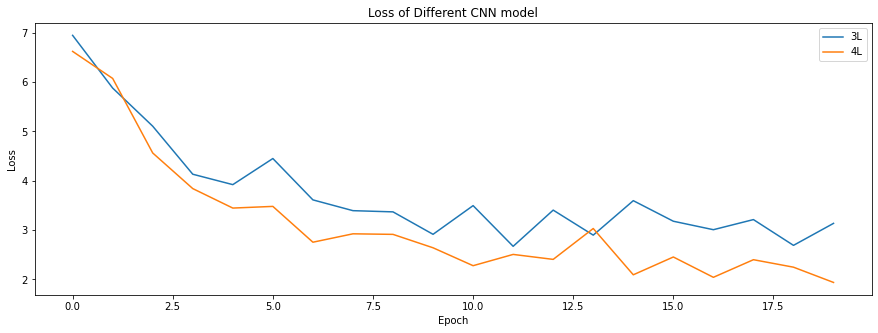

In [21]:
# print(len(summary_4_layers['loss'][0]))
names = ['3L', '4L']
plt.figure(figsize=(15,5))
plt.plot(summary_3_layers['loss'][0])
plt.plot(summary_4_layers['loss'][0])
plt.title('Loss of Different CNN model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
plt.show()

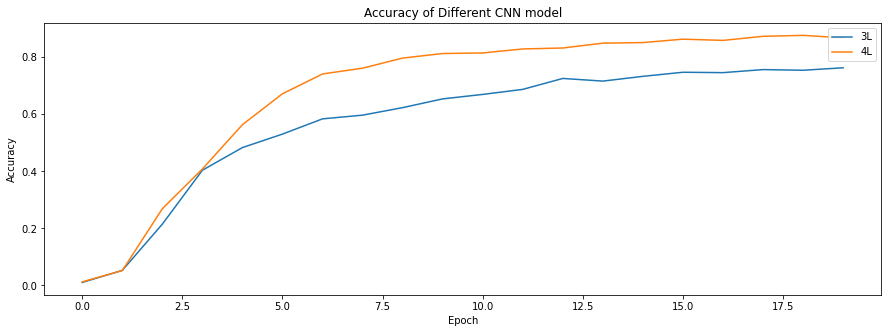

In [25]:
names = ['3L', '4L']
plt.figure(figsize=(15,5))
plt.plot(summary_3_layers['score'][0])
plt.plot(summary_4_layers['score'][0])
plt.title('Accuracy of Different CNN model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()

## Compare Hyperparameters for CNNs with 4 Layers

### -- Choose Dropout Rate

In [26]:
summary_4_layers = {'model' : [], 'loss' : [], 'score' : []}
dropouts = [0.1, 0.25, 0.5]
for dp in dropouts:
    model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=dp, epochs=20)
    summary_4_layers['model'].append(model)
    summary_4_layers['loss'].append(loss)
    summary_4_layers['score'].append(score)

[Finished Training] Score: 0.8780 Loss: 1.6089
[Finished Training] Score: 0.8593 Loss: 1.9224
[Finished Training] Score: 0.7077 Loss: 3.4916


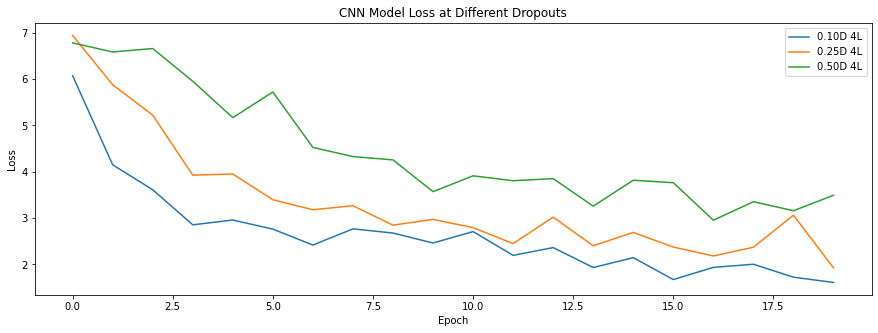

In [27]:
names = ['0.10D 4L', '0.25D 4L', '0.50D 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_4_layers['loss'][i])
plt.title('CNN Model Loss at Different Dropouts')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
plt.show()

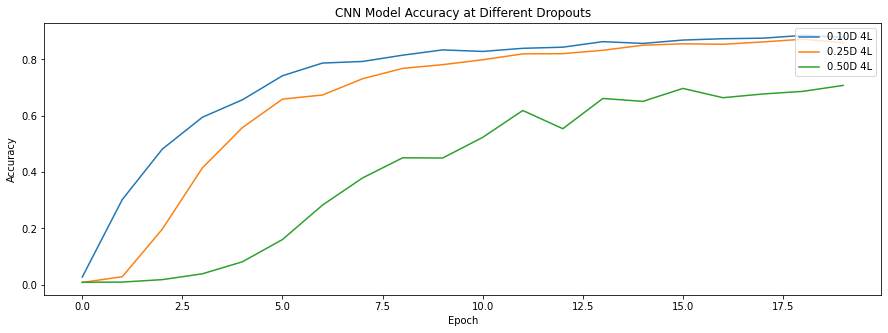

In [28]:
names = ['0.10D 4L', '0.25D 4L', '0.50D 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_4_layers['score'][i])
plt.title('CNN Model Accuracy at Different Dropouts')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()

### -- Choose Optimal Learning Rate

In [29]:
summary_4_layers = {'model' : [], 'loss' : [], 'score' : []}
learning_rate = [1e-3, 1e-2, 1e-1]
for lr in learning_rate:
    model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=20, learning_rate=lr)
    summary_4_layers['model'].append(model)
    summary_4_layers['loss'].append(loss)
    summary_4_layers['score'].append(score)

[Finished Training] Score: 0.8783 Loss: 1.8981
[Finished Training] Score: 0.7777 Loss: 3.0395
[Finished Training] Score: 0.0043 Loss: 7.0513


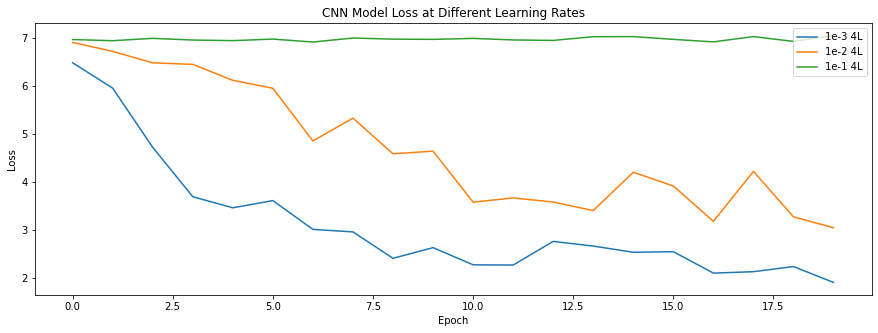

In [30]:
names = ['1e-3 4L', '1e-2 4L', '1e-1 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_4_layers['loss'][i])
plt.title('CNN Model Loss at Different Learning Rates')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()

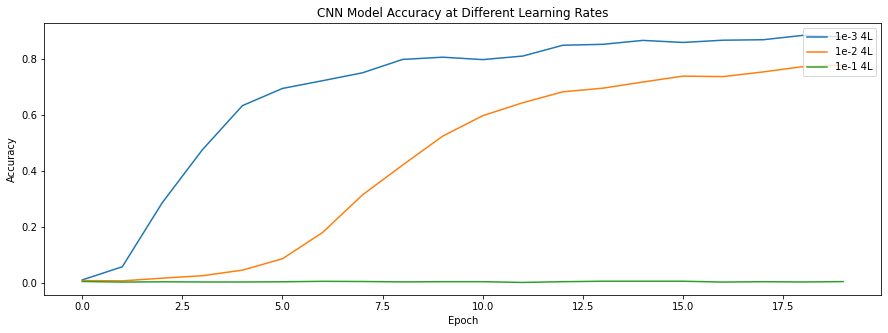

In [31]:
names = ['1e-3 4L', '1e-2 4L', '1e-1 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_4_layers['score'][i])
plt.title('CNN Model Accuracy at Different Learning Rates')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()

In [10]:
model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=20, learning_rate=1e-4)

[Finished Training] Score: 0.7120 Loss: 2.8082


In [11]:
model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=20, learning_rate=5e-4)

[Finished Training] Score: 0.8777 Loss: 2.0156


## Batch Comparison

[Finished Training] Score: 0.4133 Loss: 3.7199
[Finished Training] Score: 0.6850 Loss: 3.2950
[Finished Training] Score: 0.7007 Loss: 3.2244
[Finished Training] Score: 0.6840 Loss: 3.3203


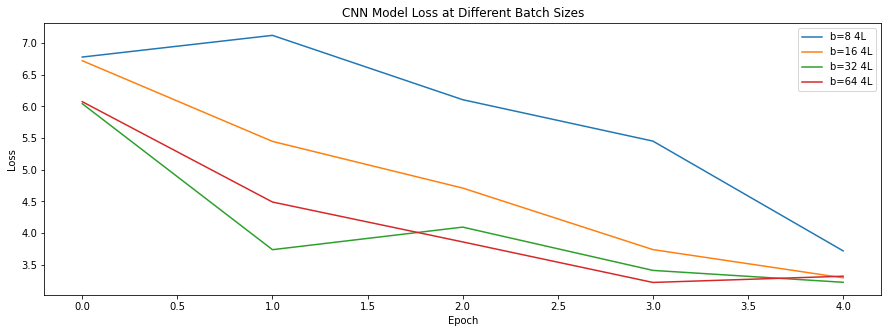

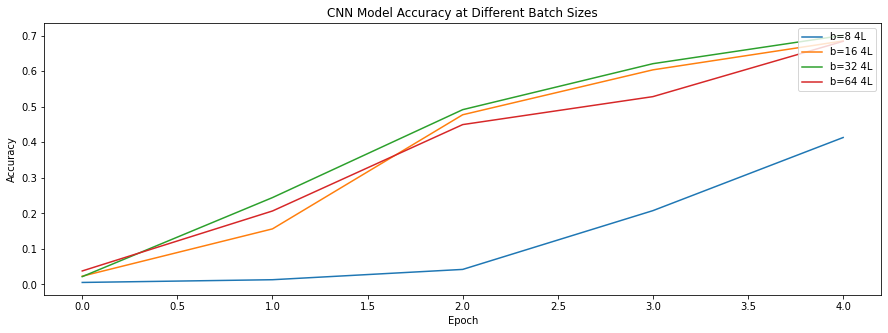

In [16]:
summary_4_layers = {'model' : [], 'loss' : [], 'score' : []}
batch = [8, 16, 32, 64]
for b in batch:
    batch_size = b
    # Loading
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)
    model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=5)
    summary_4_layers['model'].append(model)
    summary_4_layers['loss'].append(loss)
    summary_4_layers['score'].append(score)
#loss  
names = ['b=8 4L', 'b=16 4L', 'b=32 4L', 'b=64 4L']
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(summary_4_layers['loss'][i])
plt.title('CNN Model Loss at Different Batch Sizes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()
#accuracy
names = ['b=8 4L', 'b=16 4L', 'b=32 4L', 'b=64 4L']
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(summary_4_layers['score'][i])
plt.title('CNN Model Accuracy at Different Batch Sizes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='upper right')
axes = plt.gca()
# axes.set_ylim([0.85,1])
plt.show()

In [2]:
import cv2
def denoise(src):
    blur_data=cv2.GaussianBlur(src, (3,1), 0)
train_data = pd.read_pickle('images_l.pkl')
train_labels = pd.read_pickle('labels_l.pkl')
test_data = pd.read_pickle('images_test.pkl')

number_train_images = int(train_data.shape[0] * 0.9)

X_train = train_data[:number_train_images]
y_train = train_labels[:number_train_images]
print(X_train.shape)
print(y_train.shape)

X_validation = train_data[number_train_images:]
y_validation = train_labels[number_train_images:]

print(X_validation.shape)
print(y_validation.shape)
print(test_data.shape)

ImportError: DLL load failed while importing cv2: 找不到指定的模块。

## Best Model

[Finished Training] Score: 0.9170 Loss: 1.4162


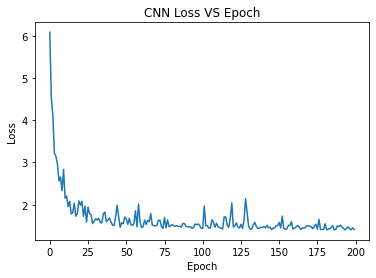

In [9]:
model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=0.1, epochs=200, learning_rate=1e-3)
plt.plot(loss)
plt.title('CNN Loss VS Epoch')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.show()

## Prediction on Test Set

In [10]:
test_predictions = predict(model, test_loader)
print(test_predictions[0])
test_predictions = test_predictions.detach().numpy()

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [11]:
new_list=[]
for element in test_predictions:
    sub_new_list=''
    for sub_element in element:
        sub_new_list+=str(int(sub_element))
    new_list.append(sub_new_list)
    
d = {'# Id' : [x for x in range(0, len(test_predictions))], 'Category' : new_list}
print(len(d['Category']))
submission = pd.DataFrame(d)
submission.to_csv(path_or_buf='submission1.csv', index=False)

15000
